In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os

/var/folders/h6/6w1fv4ks2hq54txlt9l2ygy00000gn/T/ipykernel_85941/697148563.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
filepath = 'indian-national-level-election.csv'
df = pd.read_csv(filepath)
df.columns


Index(['st_name', 'year', 'pc_no', 'pc_name', 'pc_type', 'cand_name',
       'cand_sex', 'partyname', 'partyabbre', 'totvotpoll', 'electors'],
      dtype='object')

In [4]:
df['st_name'].unique()

array(['Andaman & Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chattisgarh', 'Chhattisgarh',
       'Dadra & Nagar Haveli', 'Daman & Diu', 'Delhi', 'Goa',
       'Goa Daman & Diu', 'Goa, Daman & Diu', 'Gujarat', 'Haryana',
       'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand', 'Karnataka',
       'Kerala', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra',
       'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'National Capital Territory Of Delhi', 'Nct Of Delhi', 'Odisha',
       'Orissa', 'Pondicherry', 'Puducherry', 'Punjab', 'Rajasthan',
       'Sikkim', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'Uttarakhand',
       'Uttaranchal', 'West Bengal'], dtype=object)

In [59]:
import pandas as pd

def abbreviate(name):
    parts = name.split()
    if len(parts) > 1:
        abbreviation = "".join([word[0] for word in parts])
        abbreviation = abbreviation.replace("(", "")
    else:
        abbreviation = name
    return abbreviation

def merge(name):
    parts = name.split()
    if len(parts) > 1:
        abbreviation = "".join([word[0] for word in parts])
        abbreviation = abbreviation.replace("(", " ")
        abbreviation = abbreviation.split()[0]
    else:
        if '(' in name:
            abbreviation = name.replace("(", " ")
            abbreviation = abbreviation.split()[0]
        else:
            abbreviation = name
    return abbreviation

def total_votes(state_name, data):
    state_data = data[data['st_name'] == state_name]
    result = {}

    grouped_data = state_data.groupby(['year', 'pc_no'])
    for (year, pc_no), group in grouped_data:
        
        if year not in result:
            result[year] = {}
            
        total_votes_by_party = group.groupby('partyabbre')['totvotpoll'].sum().to_dict()
        result[year][pc_no] = total_votes_by_party
    
    return result

def select_top_partyabbre(ratio_data, **kwargs):
    top_parties_result = {}
    
    alliance = kwargs.get('alliance', None)
    upa, exit_upa = None, None
    nda, exit_nda = None, None
    if alliance is not None:
        upa, exit_upa = alliance.get('upa')
        nda, exit_nda = alliance.get('nda')
    
    for year, ac_nos in ratio_data.items():
        top_parties_result[year] = {}
    
        for pc_no, parties_ratio in ac_nos.items():
            top_parties = sorted(parties_ratio.items(), key=lambda x: x[1], reverse=True)[:5]
            top_parties_result[year][pc_no] = dict(top_parties)
    
    #print(top_parties_result)
    
    for year, ac_nos in top_parties_result.items():
        for ac_no, party_votes in ac_nos.items():
            nda_tally = 0
            upa_tally = 0
            keys_to_remove = []
            for party, votes in party_votes.items():
                if party in nda:
                    nda_tally += votes
                    keys_to_remove.append(party)
                    
                    if party in exit_nda:
                        if int(year) >= exit_nda[party]:
                            nda_tally -= votes
                            keys_to_remove = keys_to_remove[:-1]
                            
                elif party in upa:
                    upa_tally += votes
                    keys_to_remove.append(party)
                    if party in exit_upa:
                        if int(year) >= exit_upa[party]:
                            upa_tally -= votes
                            keys_to_remove = keys_to_remove[:-1]
                            
            party_votes.update({'NDA':nda_tally})
            party_votes.update({'UPA':upa_tally})
            
            print(keys_to_remove)
            for key in keys_to_remove:
                party_votes.pop(key, None)
            
        top_parties_result[year][ac_no] = party_votes
    
    
    return top_parties_result

def aggregate_and_ratio_per_party(ratio_data, **kwargs):
    aggregated_parties_result = {}

    for year, ac_nos in ratio_data.items():
        year_aggregate = {}
        total_votes_year = 0

        # Sum votes for each party across all ac_nos in the year
        for pc_no, parties_ratio in ac_nos.items():
            for party, votes in parties_ratio.items():
                year_aggregate[party] = year_aggregate.get(party, 0) + votes
                total_votes_year += votes  # Accumulate total votes for the year

        
        #ordered_aggregate = {party: [total_votes, round(total_votes / total_votes_year, 4) if total_votes_year else 0]
        #                     for party, total_votes in year_aggregate.items()}
        
        # Calculate the ratio for each party
        ordered_aggregate = {}
        for party, total_votes in year_aggregate.items():
            if total_votes_year > 0:
                proportion = round(total_votes / total_votes_year, 4)
            else:
                proportion = 0
            
            if proportion > 0.05:
                ordered_aggregate[party] = [total_votes, proportion]

        aggregated_parties_result[year] = ordered_aggregate

    return aggregated_parties_result



In [60]:
class DataPipeline:
    def __init__(self, root):
        csv = os.path.join(root, "indian-national-level-election.csv")
        nda = os.path.join(root, "NDA.txt")
        upa = os.path.join(root, "UPA.txt")
        states = os.path.join(root, "states.txt")
        exit_nda = os.path.join(root, "exit_NDA.json")
        exit_upa = os.path.join(root, "exit_UPA.json")
        
        self.df = pd.read_csv(csv)
        self.states = self.read_file(states)
        self.upa = self.read_file(upa)
        self.nda = self.read_file(nda)
        self.exit_upa = self.read_file(exit_upa)
        self.exit_nda = self.read_file(exit_nda)
        
        print(f"UPA:{self.upa}")
        print(f"NDA:{self.nda}")

        
        self.df['year'] = self.df['year'].replace(2005.1, 2005)
        self.df['year'] = self.df['year'].astype(int)
        self.df['totvotpoll'] = self.df['totvotpoll'].replace([np.inf, np.nan], 0)
        self.df['totvotpoll'] = self.df['totvotpoll'].astype(int)
        self.df['partyabbre'] = self.df['partyabbre'].replace([np.inf, np.nan], "")
    
    def read_file(self, path):
        if path.endswith('.txt'):
            with open(path, 'r') as f:
                parties = f.readlines()
                parties = [party.strip() for party in parties]
            return parties
        
        if path.endswith('.json'):
            out = {}
            with open(path, 'r') as f:
                js = json.load(f)
                for year, parties in js.items():
                    for party in parties:
                        out.update({party:int(year)})
            return out
                    
    
    def clean_pipeline(self, transforms):
        for func in transforms:
            self.df['partyabbre'] = self.df['partyabbre'].apply(func)

    def total_votes(self, state_name):
        state_data = self.df[self.df['st_name'] == state_name]
        # print(state_data)
        result = {}

        grouped_data = state_data.groupby(['year', 'pc_no'])
        for (year, pc_no), group in grouped_data:
            
            if year not in result:
                result[year] = {}
                
            total_votes_by_party = group.groupby('partyabbre')['totvotpoll'].sum().to_dict()
            result[year][pc_no] = total_votes_by_party
        
        return result
    
    def process_pipeline(self, transforms):
        tot_votesofparties_per_state = {}
        for state in self.states:
            temp = self.total_votes(state)
            tot_votesofparties_per_state.update({state: temp})

        results = {}
        alliance = {
            'upa':[self.upa, self.exit_upa],
            'nda':[self.nda, self.exit_nda]
        }
        for state in self.states:
            temp = tot_votesofparties_per_state[state]
            for func in transforms:
                temp = func(temp, alliance=alliance)

            results.update({state:temp})

        return results

project_root = "/Users/anuragkumar/Anurag/Intro_to_Data_Viz/Final_Project/DV-Proj"
#file_path = "indian-national-level-election.csv"
data_pipe = DataPipeline(project_root)

data_pipe.clean_pipeline([abbreviate, merge])

results = data_pipe.process_pipeline([select_top_partyabbre, aggregate_and_ratio_per_party])

 


UPA:['INC', 'DMK', 'NCP', 'RJD', 'IUML', 'JKNC', 'JMM', 'MDMK', 'RSP', 'VCK', 'AJP', 'GFP', 'KC', 'RMP', 'RMPI', 'AGM', 'NCK', 'PWPI']
NDA:['BJP', 'NPP', 'AJSUP', 'AINRC', 'ADS', 'AAGP', 'HSPDP', 'IPFT', 'JDS', 'JDU', 'LJPRV', 'MGP', 'NPF', 'NCP', 'NDPP', 'RLJP', 'SHS', 'SKM', 'TDP', 'TMP', 'UDP', 'UPPL', 'AMNK', 'BDJS', 'GNLF', 'HLP', 'HAM', 'JSS', 'JSP', 'KKC', 'NP', 'PJP', 'PMK', 'PNK', 'RLD', 'RLM', 'RSP', 'RPIA', 'SBSP', 'TMCM']
['INC']
['INC']
['INC']
['INC']
['INC', 'BJP']
['INC', 'BJP']
['INC', 'BJP']
['BJP', 'INC', 'NCP']
['INC', 'BJP', 'NCP']
['BJP', 'INC', 'RJD', 'NCP']
['BJP', 'INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC']
['INC

In [61]:
results['Uttar Pradesh']

{1977: {'BLD': [19530435, 0.6807],
  'IND': [1561852, 0.0544],
  'UPA': [7170182, 0.2499]},
 1980: {'IND': [2452079, 0.0866],
  'JNP': [14614002, 0.5159],
  'UPA': [10596471, 0.3741]},
 1984: {'LKD': [7360053, 0.2172],
  'IND': [4356347, 0.1285],
  'NDA': [2186430, 0.0645],
  'UPA': [17391831, 0.5132]},
 1989: {'IND': [3208568, 0.0839],
  'NDA': [2933977, 0.0767],
  'UPA': [12393934, 0.3242],
  'JD': [14004513, 0.3663],
  'BSP': [3788253, 0.0991]},
 1991: {'JD': [7950431, 0.22],
  'JP': [3782917, 0.1047],
  'NDA': [12306701, 0.3406],
  'UPA': [6755015, 0.1869],
  'BSP': [3103998, 0.0859]},
 1996: {'SP': [9576610, 0.2129],
  'IND': [2875051, 0.0639],
  'NDA': [15387632, 0.3421],
  'UPA': [3584813, 0.0797],
  'BSP': [9470450, 0.2106]},
 1998: {'SP': [16018232, 0.291],
  'BSP': [11670682, 0.212],
  'NDA': [20369694, 0.37],
  'UPA': [3314291, 0.0602]},
 1999: {'SP': [13076453, 0.2453],
  'BSP': [11859276, 0.2225],
  'NDA': [16373063, 0.3071],
  'UPA': [8001685, 0.1501]},
 2004: {'BSP': [13

In [51]:
results['Uttar Pradesh']

{1977: {'BLD': [19530435, 0.6807],
  'IND': [1561852, 0.0544],
  'upa': [7170182, 0.2499]},
 1980: {'IND': [2452079, 0.0865],
  'JNP': [14614002, 0.5154],
  'upa': [10624803, 0.3747]},
 1984: {'LKD': [7360053, 0.2172],
  'IND': [4356347, 0.1285],
  'nda': [2186430, 0.0645],
  'upa': [17391831, 0.5132]},
 1989: {'IND': [3208568, 0.0839],
  'nda': [2933977, 0.0767],
  'upa': [12393934, 0.3242],
  'JD': [14004513, 0.3663],
  'BSP': [3788253, 0.0991]},
 1991: {'JD': [7950431, 0.22],
  'JP': [3782917, 0.1047],
  'nda': [12306701, 0.3406],
  'upa': [6755015, 0.1869],
  'BSP': [3103998, 0.0859]},
 1996: {'SP': [9576610, 0.2129],
  'IND': [2875051, 0.0639],
  'nda': [15387632, 0.3421],
  'upa': [3584813, 0.0797],
  'BSP': [9470450, 0.2106]},
 1998: {'SP': [16018232, 0.291],
  'BSP': [11670682, 0.212],
  'nda': [20369694, 0.37],
  'upa': [3314291, 0.0602]},
 1999: {'SP': [13076453, 0.2453],
  'BSP': [11859276, 0.2225],
  'nda': [16373063, 0.3071],
  'upa': [8001685, 0.1501]},
 2004: {'BSP': [13

In [20]:
# df['year'] = df['year'].replace(2005.1, 2005)
# df['year'] = df['year'].astype(int)
# df['totvotpoll'] = df['totvotpoll'].replace([np.inf, np.nan], 0)
# df['totvotpoll'] = df['totvotpoll'].astype(int)
# df['partyabbre'] = df['partyabbre'].replace([np.inf, np.nan], "")
# df['partyabbre'] = df['partyabbre'].apply(abbreviate)
# df['partyabbre'] = df['partyabbre'].apply(merge)
# AP = total_votes('Andhra Pradesh', df)
# top_parties_AP = select_top_partyabbre(AP)
# agg = aggregate_and_ratio_per_party(top_parties_AP)
# print(agg)


In [29]:
# Converting int64 keys to string
def convert_keys_to_string(dictionary):
    if isinstance(dictionary, dict):
        return {str(key): convert_keys_to_string(value) for key, value in dictionary.items()}
    elif isinstance(dictionary, list):
        return [convert_keys_to_string(element) for element in dictionary]
    else:
        return dictionary

# Define the output file path
output_file = "results.json"

# Convert the dictionary keys to string
results_str_keys = convert_keys_to_string(results)

# Convert the dictionary to JSON format
json_data = json.dumps(results_str_keys, indent=8)

# Write the JSON data to a file
with open(output_file, "w") as json_file:
    json_file.write(json_data)

print(f"JSON data has been written to {output_file}")

JSON data has been written to results.json


In [20]:
# df['year'] = df['year'].replace(2005.1, 2005)
# df['year'] = df['year'].astype(int)
# df['totvotpoll'] = df['totvotpoll'].replace([np.inf, np.nan], 0)
# df['totvotpoll'] = df['totvotpoll'].astype(int)
# df['partyabbre'] = df['partyabbre'].replace([np.inf, np.nan], "")
# df['partyabbre'] = df['partyabbre'].apply(abbreviate)
# df['partyabbre'] = df['partyabbre'].apply(merge)
# AP = total_votes('Andhra Pradesh', df)
# top_parties_AP = select_top_partyabbre(AP)
# agg = aggregate_and_ratio_per_party(top_parties_AP)
# print(agg)


In [ ]:
import matplotlib.pyplot as plt

def plot_stacked_party_ratios(aggregated_data):
    years = sorted(aggregated_data.keys())
    parties_order = ['IND', 'BJP', 'TDP', 'INC', 'CPM', 'CPI']
    
    # Initialize a dict to hold the ratios for each party
    ratios_per_party = {party: [] for party in parties_order}

    # Populate the ratios for each party and each year
    for year in years:
        for party in parties_order:
            # Get the party data for the year, default to (0, 0) if not found
            party_data = aggregated_data[year].get(party, (0, 0))
            
            # Access the ratio, which is the second element of the tuple
            ratio = party_data[1]
            ratios_per_party[party].append(ratio)

    # Create the stacked bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = [0] * len(years)
    
    for party in parties_order:
        ax.bar(years, ratios_per_party[party], bottom=bottom, label=party)
        bottom = [bottom[i] + ratios_per_party[party][i] for i in range(len(years))]

    ax.set_xlabel('Year')
    ax.set_ylabel('Proportion of Total Votes')
    ax.set_title('Stacked Proportion of Total Votes by Party and Year')
    ax.legend(title='Party', loc='best', fontsize='small')

    plt.xticks(years, rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
plot_stacked_party_ratios(AP_aggregate)

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


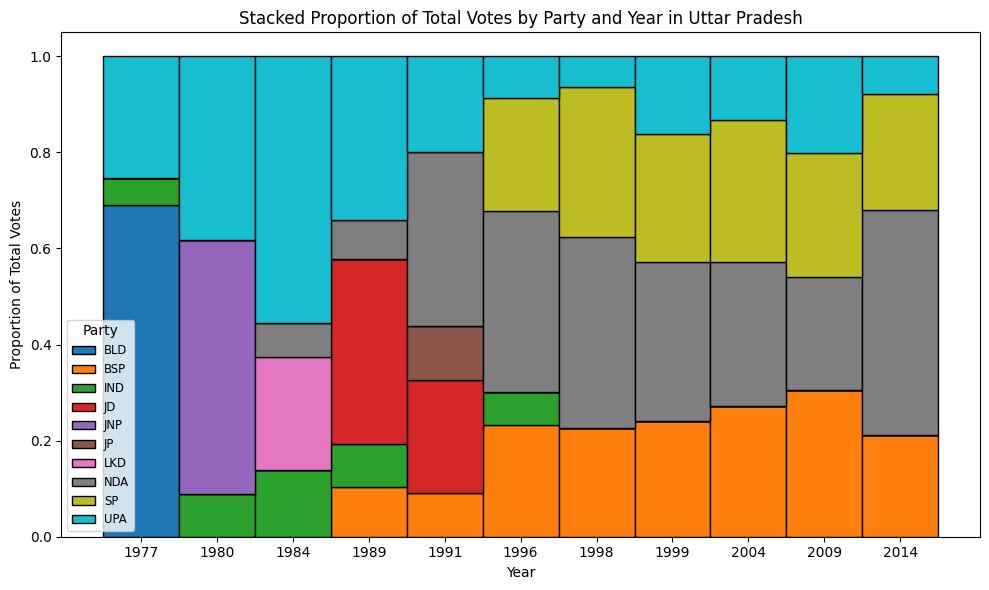

In [66]:
import matplotlib.pyplot as plt

def plot_stacked_party_ratios_by_state(aggregated_data, state):

    years = sorted(aggregated_data[state].keys())

    # Dynamically determine the parties present in the state data
    parties = set()
    for year in years:
        parties.update(aggregated_data[state][year].keys())
    parties_order = sorted(parties)
    #parties_order = ['UPA', 'BJP', 'IND']

    # Initialize a dict to hold the ratios for each party
    ratios_per_party = {party: [] for party in parties_order}

    # Populate the ratios for each party and each year
    for year in years:
        year_total = sum(votes for _, votes in aggregated_data[state][year].values())
        for party in parties_order:
            # Get the party data for the year, default to (0, 0) if not found
            party_data = aggregated_data[state][year].get(party, (0, 0))

            # Calculate the ratio if year_total is not zero
            ratio = party_data[1] / year_total if year_total else 0
            ratios_per_party[party].append(ratio)

    # Create the stacked bar plot for each state
    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = [0] * len(years)
    
    years_axis = {i:str(y) for i, y in enumerate(list(years))}
    print(years_axis)
    for party in parties_order:
        ax.bar(years_axis.keys(), ratios_per_party[party], bottom=bottom, label=party, width=1, edgecolor='black')
        bottom = [bottom[i] + ratios_per_party[party][i] for i in range(len(years))]

    ax.set_xlabel('Year')
    ax.set_ylabel('Proportion of Total Votes')
    ax.set_title(f'Stacked Proportion of Total Votes by Party and Year in {state}')
    ax.legend(title='Party', loc='best', fontsize='small')
    ax.set_xticks(list(years_axis.keys()))
    ax.set_xticklabels(list(years_axis.values()))
   
    plt.tight_layout()
    plt.show()
     

# Example usage (assuming the data structure supports state-wise aggregation)
plot_stacked_party_ratios_by_state(results, 'Uttar Pradesh')
